nama : Mahendra krs

Proyek Pertama : Membuat Model NLP dengan TensorFlow

In [ ]:
import tensorflow as tf
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy()
print("Number of accelerators: ", strategy.num_replicas_in_sync)

Number of accelerators:  1


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import pandas as pd
df=pd.read_csv('drive/My Drive/bbc_data.csv')
df.info()

category = pd.get_dummies(df.labels)
df_new = pd.concat([df, category], axis=1)
df_new = df_new.drop(columns='labels')

content = df_new['data'].values
label = df_new[['business', 'entertainment', 'politics', 'sport', 'tech']].values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   data    2225 non-null   object
 1   labels  2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB


In [ ]:
from sklearn.model_selection import train_test_split
content_train, content_test, label_train, label_test = train_test_split(content, label, test_size=0.2)

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=5000, oov_token='x')
tokenizer.fit_on_texts(content_train)

sequence_train = tokenizer.texts_to_sequences(content_train)
sequence_test = tokenizer.texts_to_sequences(content_test)

padded_train = pad_sequences(sequence_train)
padded_test = pad_sequences(sequence_test)

max_length = 100


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=6, min_lr=0.0001)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=5000, output_dim=16),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(5, activation='softmax')
])
model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),metrics=['accuracy'])

In [ ]:
num_epochs = 100
history = model.fit(padded_train, label_train, epochs=num_epochs,
                    validation_data=(padded_test, label_test), verbose=2,
                    callbacks=[early_stopping, model_checkpoint, reduce_lr],
                    batch_size=64,
                    )

Epoch 1/100
28/28 - 116s - loss: 1.6067 - accuracy: 0.2258 - val_loss: 1.6037 - val_accuracy: 0.2157 - lr: 0.0010 - 116s/epoch - 4s/step
Epoch 2/100
28/28 - 112s - loss: 1.5847 - accuracy: 0.2584 - val_loss: 1.5103 - val_accuracy: 0.3685 - lr: 0.0010 - 112s/epoch - 4s/step
Epoch 3/100
28/28 - 111s - loss: 1.4395 - accuracy: 0.4084 - val_loss: 1.2493 - val_accuracy: 0.4315 - lr: 0.0010 - 111s/epoch - 4s/step
Epoch 4/100
28/28 - 112s - loss: 1.1477 - accuracy: 0.4624 - val_loss: 1.1921 - val_accuracy: 0.4629 - lr: 0.0010 - 112s/epoch - 4s/step
Epoch 5/100
28/28 - 109s - loss: 0.9516 - accuracy: 0.5787 - val_loss: 0.9349 - val_accuracy: 0.5640 - lr: 0.0010 - 109s/epoch - 4s/step
Epoch 6/100
28/28 - 117s - loss: 0.6285 - accuracy: 0.7124 - val_loss: 0.6546 - val_accuracy: 0.7101 - lr: 0.0010 - 117s/epoch - 4s/step
Epoch 7/100
28/28 - 108s - loss: 0.4113 - accuracy: 0.8242 - val_loss: 0.6378 - val_accuracy: 0.7955 - lr: 0.0010 - 108s/epoch - 4s/step
Epoch 8/100
28/28 - 118s - loss: 0.2458 -

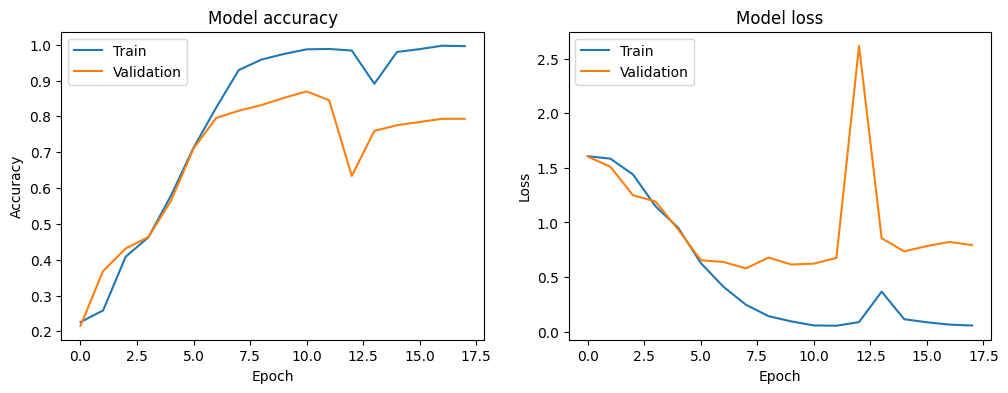

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')